<a href="https://colab.research.google.com/github/today-dawoon/aib-project/blob/main/section2_project_cardio_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### **0. 프로젝트 설명**
개인의 건강정보를 통해 cardio 여부를 분류 예측하기

  - age: 나이
  - gender: 성별 | binary
  - height: 키
  - weight: 몸무게
  - ap_hi: 최고혈압
  - ap_lo: 최저혈압
  - cholesterol: 콜레스테롤 수치 | 1: normal, 2: above normal, 3: well above normal 
  - gluc: 혈당 | 1: normal, 2: above normal, 3: well above normal
  - smoke: 흡연여부 | binary
  - alco: 음주여부 | binary
  - active: 활동성 | binary
  - cardio: 심장병 | binary (target)

##### **1. 데이터 선정 이유 및 문제 정의**
  - 종합적 건강 정보를 통해 cardio disease 확인
  - 분류 문제로 cardio 여부를 예측

##### **2. EDA와 데이터 전처리**
  - id: 제거
  - age: day -> year
  - ap_hi, ap_lo: 둘의 차이를 ap_lohi

##### **3. 데이터를 이용한 가설 및 평가지표, 베이스라인 선택**
  - 가설1) 분류 모델 중 XGB가 성능이 가장 좋을 것이다.
  - 가설2) cardio 여부에 age가 가장 주요한 feature일 것이다.

  - 평가지표: AUC

  - 베이스라인: target이 0인 값



##### **4. 머신러닝 방식 적용 및 교차검증**
  - decision tree, random forest, xgboost 세가지 모델 학습
  - 위의 세가지 모델 cv로 일반화 가능성 확인
  - RandomizedSearchCV로 하이퍼 파라미터 튜닝
  - 평가지표인 auc가 높은 xgboost 모델의 thresh 조절로 최적화

##### **5. 머신러닝 모델 해석**
  - Permutation Importance
  - SHAP

## 2. EDA와 데이터 전처리

In [ ]:
!pip install category_encoders
!pip install pdpbox
!pip install shap
!pip install eli5

##### **데이터 불러오기**

In [ ]:
# library import
import pandas as pd
import numpy as np

from scipy.stats import randint, uniform

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, f1_score, accuracy_score, roc_curve, roc_auc_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from category_encoders import TargetEncoder, OrdinalEncoder, OneHotEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import shap
import eli5
import xgboost


from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [6]:
df = pd.read_csv('/content/cardio.csv', sep=',')
df.drop('id', axis=1, inplace=True)

df

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
24521,17999,1,165,75.0,130,90,1,1,0,0,0,1
24522,22571,1,154,68.0,160,80,1,2,0,0,1,1
24523,22529,2,165,68.0,120,80,1,1,0,0,1,0
24524,14592,1,167,62.0,120,80,1,1,0,0,1,0


##### **EDA**

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24526 entries, 0 to 24525
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          24526 non-null  int64  
 1   gender       24526 non-null  int64  
 2   height       24526 non-null  int64  
 3   weight       24526 non-null  float64
 4   ap_hi        24526 non-null  int64  
 5   ap_lo        24526 non-null  int64  
 6   cholesterol  24526 non-null  int64  
 7   gluc         24526 non-null  int64  
 8   smoke        24526 non-null  int64  
 9   alco         24526 non-null  int64  
 10  active       24526 non-null  int64  
 11  cardio       24526 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 2.2 MB


In [8]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,24526.000000,24526.000000,24526.000000,24526.000000,24526.000000,24526.000000,24526.000000,24526.000000,24526.000000,24526.000000,24526.000000,24526.000000
mean,19457.431746,1.350241,164.396192,74.179946,127.340251,97.671940,1.363084,1.224170,0.090639,0.054840,0.803719,0.495311
std,2473.781894,0.477055,8.207848,14.348754,76.737951,212.906315,0.677518,0.569619,0.287100,0.227672,0.397192,0.499988
min,10798.000000,1.000000,55.000000,30.000000,-140.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17645.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19696.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21316.000000,2.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23690.000000,2.000000,250.000000,200.000000,11500.000000,10000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
df['age'] = (df['age']/365).astype(int)
df['ap_lohi'] = df['ap_hi'] - df['ap_lo']

In [10]:
df['cardio'].value_counts(normalize=True)

0    0.504689
1    0.495311
Name: cardio, dtype: float64

##### **training, test, val 데이터셋 분리**

In [11]:
target = 'cardio'

train, test = train_test_split(df,
                              test_size=0.2, 
                              stratify=df[target], 
                              random_state=2
                              )

train, val = train_test_split(train,
                              test_size=0.2, 
                              stratify=train[target], 
                              random_state=2
                              )

train.shape, val.shape, test.shape

((15696, 13), (3924, 13), (4906, 13))

In [12]:
features = train.drop(columns=target).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

## 3. 데이터를 이용한 가설 및 평가지표, 베이스라인 선택
  - 가설1) 분류 모델 중 XGB가 성능이 가장 좋을 것이다.
  - 가설2) cardio 여부에 age가 가장 주요한 feature일 것이다.

  - 분류모델이므로 target의 mode인 0을 베이스라인 모델을 삼고 auc를 측정한다.

In [13]:
y_train.value_counts(normalize=True)

0    0.504715
1    0.495285
Name: cardio, dtype: float64

In [14]:
y_train_pred = [0] * len(y_train)
print('accuracy:', accuracy_score(y_train, y_train_pred))
print('f1:',f1_score(y_train, y_train_pred))
print('auc:', roc_auc_score(y_train, y_train_pred))

accuracy: 0.5047145769622834
f1: 0.0
auc: 0.5


## 4. 머신러닝 방식 적용 및 교차검증

#### 가설1) 분류 모델 중 XGBoost가 가장 성능이 좋을 것이다.

In [15]:
# decisiontree

pipe_dt = make_pipeline(
    TargetEncoder(), 
    SimpleImputer(), 
    DecisionTreeClassifier(random_state=2)
)

pipe_dt.fit(X_train, y_train)

print('<<train data>>')
print('accuracy:', pipe_dt.score(X_train, y_train))
print('f1:', f1_score(y_train, pipe_dt.predict(X_train)))
print('auc:', roc_auc_score(y_train, pipe_dt.predict(X_train)))

print('\n<<validation data>>')
print('accuracy:', pipe_dt.score(X_val, y_val))
print('f1:', f1_score(y_val, pipe_dt.predict(X_val)))
print('auc:', roc_auc_score(y_val, pipe_dt.predict(X_val)))

<<train data>>
accuracy: 0.992737003058104
f1: 0.9926165803108806
auc: 0.9926714719869383

<<validation data>>
accuracy: 0.6241080530071356
f1: 0.6167835801506885
auc: 0.6239852225963338


In [16]:
# rf

pipe_rf = make_pipeline(
    TargetEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=2)
)

pipe_rf.fit(X_train, y_train)
print('<<train data>>')
print('accuracy:', pipe_rf.score(X_train, y_train))
print('f1:', f1_score(y_train, pipe_rf.predict(X_train)))
print('auc:', roc_auc_score(y_train, pipe_rf.predict(X_train)))

print('\n<<validation data>>')
print('accuracy:', pipe_rf.score(X_val, y_val))
print('f1:', f1_score(y_val, pipe_rf.predict(X_val)))
print('auc:', roc_auc_score(y_val, pipe_rf.predict(X_val)))

<<train data>>
accuracy: 0.992737003058104
f1: 0.9926423131534787
auc: 0.9927039146211191

<<validation data>>
accuracy: 0.7161060142711518
f1: 0.7079181961195595
auc: 0.7159090909090908


In [17]:
# xgb

pipe_xgb = make_pipeline(
    TargetEncoder(), 
    SimpleImputer(), 
    XGBClassifier(random_state=2)
)

pipe_xgb.fit(X_train, y_train)
print('<<train data>>')
print('accuracy:', pipe_xgb.score(X_train, y_train))
print('f1:', f1_score(y_train, pipe_xgb.predict(X_train)))
print('auc:', roc_auc_score(y_train, pipe_xgb.predict(X_train)))

print('\n<<validation data>>')
print('accuracy:', pipe_xgb.score(X_val, y_val))
print('f1:', f1_score(y_val, pipe_xgb.predict(X_val)))
print('auc:', roc_auc_score(y_val, pipe_xgb.predict(X_val)))

<<train data>>
accuracy: 0.7433741080530072
f1: 0.7263958701263415
auc: 0.7428550375422006

<<validation data>>
accuracy: 0.7252803261977574
f1: 0.7077006507592191
auc: 0.7247895622895622


In [18]:
scores = pd.DataFrame({'decision tree': [roc_auc_score(y_train, pipe_dt.predict(X_train)), roc_auc_score(y_val, pipe_dt.predict(X_val))],
                        'random forest': [roc_auc_score(y_train, pipe_rf.predict(X_train)), roc_auc_score(y_val, pipe_rf.predict(X_val))],
                        'xgboost': [roc_auc_score(y_train, pipe_xgb.predict(X_train)), roc_auc_score(y_val, pipe_xgb.predict(X_val))]
                        }).T

scores.columns = ['train', 'val']
scores

,train,val
decision tree,0.992671,0.623985
random forest,0.992704,0.715909
xgboost,0.742855,0.724790


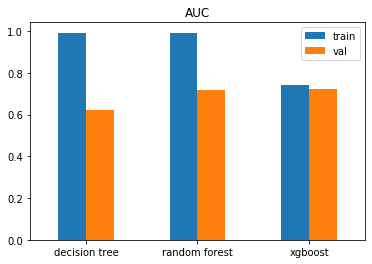

In [19]:
# 모델간 AUC 비교
scores.plot(kind='bar')
plt.title('AUC')
plt.xticks(rotation=0);

In [20]:
# cv

skf = StratifiedKFold(n_splits=20, shuffle=True, random_state=2)

score_dt = cross_val_score(pipe_dt, X_train, y_train, cv=skf).mean()
score_rf = cross_val_score(pipe_rf, X_train, y_train, cv=skf).mean()
score_xgb = cross_val_score(pipe_xgb, X_train, y_train, cv=skf).mean()

score_dt, score_rf, score_xgb

(0.6337916774990252, 0.7107554757571817, 0.7358591414272715)

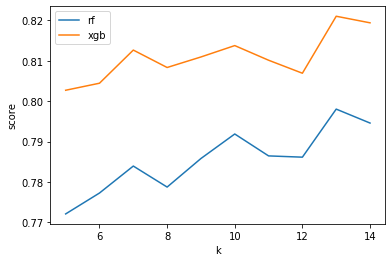

In [22]:
model_list = []
for model in [pipe_rf, pipe_xgb]:
  score_lst = []
  for k in range(5, 15):
    scores = cross_val_score(model, X_train, y_train, cv=k, scoring='roc_auc')
    score_lst.append((k,max(scores)))
  model_list.append(score_lst)

rf_x = [x[0] for x in model_list[0]]
rf_y = [x[1] for x in model_list[0]]

xgb_x = [x[0] for x in model_list[1]]
xgb_y = [x[1] for x in model_list[1]]

import matplotlib.pyplot as plt
plt.plot(rf_x, rf_y, label = 'rf')
plt.plot(xgb_x, xgb_y, label = 'xgb')
plt.xlabel('k')
plt.ylabel('score')
plt.legend()
plt.show()

##### **하이퍼파라미터 튜닝**

In [23]:
# rf: randomizedSearchCV

pipe_rf = make_pipeline(
    TargetEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=2, n_jobs=-1)
)

dists = {
    'targetencoder__smoothing': [20.,50.,60.,100.],
    'targetencoder__min_samples_leaf': randint(1, 50),
    'randomforestclassifier__n_estimators': randint(100, 1000), 
    'randomforestclassifier__min_samples_leaf': randint(1, 100),
    'randomforestclassifier__min_samples_split': randint(1, 100), 
    'randomforestclassifier__max_depth': randint(-1, 20), 
    'randomforestclassifier__max_features': uniform(0, 1) # max_features
}

rf_clf = RandomizedSearchCV(
    pipe_rf, 
    param_distributions=dists, 
    n_iter=50, 
    cv=10, 
    scoring='accuracy',  
    verbose=1,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 33.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 35.4min finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('targetencoder',
                                              TargetEncoder(cols=None,
                                                            drop_invariant=False,
                                                            handle_missing='value',
                                                            handle_unknown='value',
                                                            min_samples_leaf=1,
                                                            return_df=True,
                                                            smoothing=1.0,
                                                            verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
   

In [25]:
print('최적 하이퍼파라미터: ', rf_clf.best_params_)
print('accuracy: ', rf_clf.best_score_)

최적 하이퍼파라미터:  {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 0.668428509773027, 'randomforestclassifier__min_samples_leaf': 54, 'randomforestclassifier__min_samples_split': 23, 'randomforestclassifier__n_estimators': 869, 'targetencoder__min_samples_leaf': 14, 'targetencoder__smoothing': 60.0}
accuracy:  0.7351570435142672


In [26]:
pipe_rf = make_pipeline(
    TargetEncoder(min_samples_leaf=14, smoothing=60), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(random_state=2, n_jobs=-1, max_depth=10, max_features=0.668, min_samples_leaf=54, min_samples_split=23, n_estimators=869)
)

pipe_rf.fit(X_train, y_train)
print('<<train data>>')
print('accuracy:', pipe_rf.score(X_train, y_train))
print('f1:', f1_score(y_train, pipe_rf.predict(X_train)))
print('auc:', roc_auc_score(y_train, pipe_rf.predict(X_train)))


print('\n<<validation data>>')
print('accuracy:', pipe_rf.score(X_val, y_val))
print('f1:', f1_score(y_val, pipe_rf.predict(X_val)))
print('auc:', roc_auc_score(y_val, pipe_rf.predict(X_val)))

<<train data>>
accuracy: 0.7433741080530072
f1: 0.7266187050359713
auc: 0.742862247016463

<<validation data>>
accuracy: 0.7255351681957186
f1: 0.7080509623204121
auc: 0.7250467639356528


In [24]:
# xgb: randomizedSearchCV

pipe_xgb = make_pipeline(
    TargetEncoder(), 
    XGBClassifier(random_state = 2, n_estimators=100)
)

dists = {
    'targetencoder__smoothing': [10., 20.,50.,60.,100.],
    'targetencoder__min_samples_leaf': randint(1, 50),
    'xgbclassifier__max_depth': randint(5, 20), 
    'xgbclassifier__learning_rate': list(np.arange(0, 1, 0.01)),
    'xgbclassifier__gamma': list(np.arange(0,5,0.5)), 
    'xgbclassifier__reg_alpha:': list(np.arange(0,1,0.001)),
    'xgbclassifier__reg_lambda': list(np.arange(0,1,0.001))
}


xgb_rclf = RandomizedSearchCV(
    pipe_xgb, 
    param_distributions=dists, 
    n_iter=50, 
    cv=10,
    scoring='roc_auc',  
    verbose=1,
    n_jobs=-1
)

xgb_rclf.fit(X_train, y_train)
roc_auc_score(y_val, xgb_rclf.predict(X_val))

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 20.1min finished


0.7339319117096894

In [27]:
print('최적 하이퍼파라미터: ', xgb_rclf.best_params_)
print('accuracy: ', xgb_rclf.best_score_)

최적 하이퍼파라미터:  {'targetencoder__min_samples_leaf': 19, 'targetencoder__smoothing': 60.0, 'xgbclassifier__gamma': 3.5, 'xgbclassifier__learning_rate': 0.16, 'xgbclassifier__max_depth': 6, 'xgbclassifier__reg_alpha:': 0.659, 'xgbclassifier__reg_lambda': 0.279}
accuracy:  0.7961375132099773


In [28]:
pipe_xgb = make_pipeline(
    TargetEncoder(min_samples_leaf = 19, smoothing = 60), 
    XGBClassifier(random_state = 2, n_estimators=100, gamma=3.5, learning_rate = 0.16, max_depth=6, reg_alpha=0.659, reg_lambda = 0.279)
)

pipe_xgb.fit(X_train, y_train)
print('<<train data>>')
print('accuracy:', pipe_xgb.score(X_train, y_train))
print('f1:', f1_score(y_train, pipe_xgb.predict(X_train)))
print('auc:', roc_auc_score(y_train, pipe_xgb.predict(X_train)))


print('\n<<validation data>>')
print('accuracy:', pipe_xgb.score(X_val, y_val))
print('f1:', f1_score(y_val, pipe_xgb.predict(X_val)))
print('auc:', roc_auc_score(y_val, pipe_xgb.predict(X_val)))

<<train data>>
accuracy: 0.7517838939857289
f1: 0.7350020405387022
auc: 0.7512535554561528

<<validation data>>
accuracy: 0.7303771661569827
f1: 0.7132791327913279
auc: 0.7298915076692856


idx: 606 , threshold: 0.55584353
<<after>>
               precision    recall  f1-score   support

           0       0.70      0.83      0.76      1980
           1       0.79      0.63      0.70      1944

    accuracy                           0.73      3924
   macro avg       0.74      0.73      0.73      3924
weighted avg       0.74      0.73      0.73      3924

f1: 0.7024557395773844
auc: 0.7335297418630752


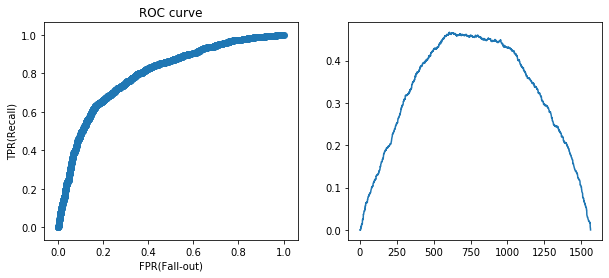

In [29]:
# thresholds
y_pred_proba = pipe_xgb.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})

# roc 시각화
plt.rcParams["figure.figsize"] = (10,4)
plt.subplot(121)
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

# 최적의 threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('idx:', optimal_idx, ', threshold:', optimal_threshold)

# auc 시각화
plt.subplot(122)
plt.plot(tpr-fpr);

# threshold 설정 및 레포트
y_pred_optimal = y_pred_proba >= optimal_threshold
print('<<after>>\n',classification_report(y_val, y_pred_optimal))

# auc 점수
auc_score = roc_auc_score(y_val, y_pred_optimal)
print('f1:',f1_score(y_val, y_pred_optimal))
print('auc:', auc_score)

테스트 정확도 0.7437831227068895
<<before>> 
               precision    recall  f1-score   support

           0       0.72      0.79      0.76      2476
           1       0.77      0.68      0.72      2430

    accuracy                           0.74      4906
   macro avg       0.74      0.74      0.74      4906
weighted avg       0.74      0.74      0.74      4906

idx: 740 , threshold: 0.5049362729720566

<<after>> 
               precision    recall  f1-score   support

           0       0.72      0.80      0.76      2476
           1       0.77      0.69      0.73      2430

    accuracy                           0.74      4906
   macro avg       0.75      0.74      0.74      4906
weighted avg       0.75      0.74      0.74      4906

f1: 0.727786226374104
auc: 0.7440847776514623


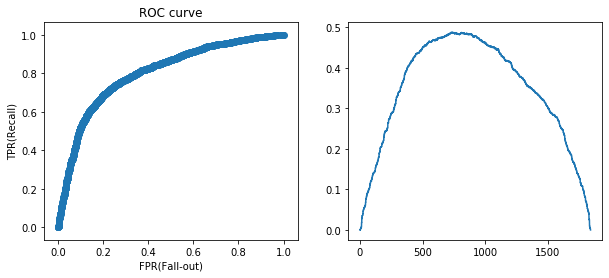

In [31]:
# 테스트 데이터 성능확인
tpred = pipe_xgb.predict(X_test)
print('테스트 정확도', pipe_rf.score(X_test, y_test))
print('<<before>> \n',classification_report(y_test, tpred))

# roc_curve(타겟값, prob of 1)
y_pred_proba = pipe_rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})

# roc 시각화
plt.rcParams["figure.figsize"] = (10,4)
plt.subplot(121)
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

# 최적의 threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('idx:', optimal_idx, ', threshold:', optimal_threshold)

# auc 시각화
plt.subplot(122)
plt.plot(tpr-fpr);

# threshold 설정 및 레포트
y_pred_optimal = y_pred_proba >= optimal_threshold
print('\n<<after>> \n',classification_report(y_test, y_pred_optimal))

# auc 점수
auc_score = roc_auc_score(y_test, y_pred_optimal)
print('f1:',f1_score(y_test, y_pred_optimal))
print('auc:', auc_score)

## 5. 모델 설명

##### **Permutation Importance**

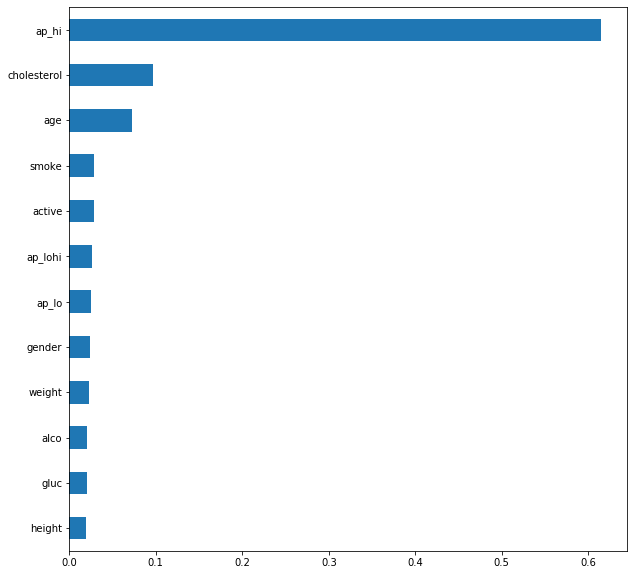

In [33]:
# feature importance
model_xgb = pipe_xgb.named_steps['xgbclassifier']

importances = pd.Series(model_xgb.feature_importances_, X_train.columns)
plt.figure(figsize=(10,10))
importances.sort_values().plot.barh();

##### **SHAP**

In [42]:
model = xgboost.XGBClassifier(random_state = 2, n_estimators=100, gamma=4, learning_rate = 0.233, max_depth=5, reg_alpha=0.906, reg_lambda = 0.038).fit(X_train, y_train)

In [35]:
shap.initjs()

explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_train.iloc[:500])
shap.force_plot(base_value=explainer.expected_value,
                shap_values = shap_values,
                features=X_train.iloc[:500])

In [36]:
row = X_test.iloc[[1]]
print('모델 예측값: ', model.predict(row))

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

모델 예측값:  [0]


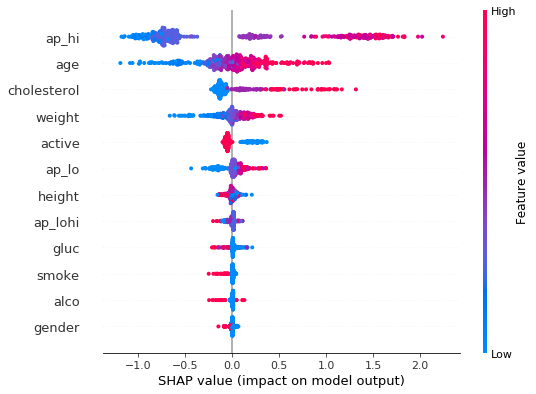

In [38]:
shap_values = explainer.shap_values(X_test.iloc[:500])
shap.summary_plot(shap_values, X_test.iloc[:500])

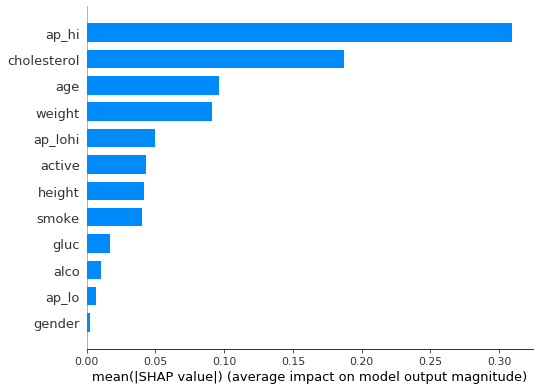

In [37]:
shap.summary_plot(shap_values, X_train, plot_type='bar');